In [1]:
from google.colab import drive
drive.mount('/gdrive')

!pip -q install SimpleITK

Mounted at /gdrive
     |████████████████████████████████| 47.4MB 60kB/s 


In [2]:
!cp -r /gdrive/MyDrive/Assignment\ 2/data/ /content/data

In [3]:
!unzip -q -u "/content/data/brats13.zip" -d /content/data/brats13/
%cd "/content/data/brats13/content/brats13" 
!mv * ../../
%cd /content
!rm -rf /content/data/brats13/content

/content/data/brats13/content/brats13
/content


In [1]:
import os
import torch
import numpy as np 
from tqdm import tqdm
from PIL import Image
from glob import glob
from skimage import io
#import SimpleITK as sitk 
from pathlib import Path
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from os.path import join, abspath as abs
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
# from SimpleITK import ReadImage, Tile, GetArrayFromImage

In [ ]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = GetArrayFromImage(img)
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure()#figsize=(5, 5))
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [ ]:
# Paths to the .mhd files
filenameF = "/content/data/brats13/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_Flair.54584.mha"
filenameT1 = "/content/data/brats13/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1.54585.mha"
filenameT2 = "/content/data/brats13/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T2.54587.mha"
filenameTC = "/content/data/brats13/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1c.54586.mha"

# Slice index to visualize with 'sitk_show'
label = "/content/data/brats13/HGG/brats_2013_pat0013_1/VSD.Brain_3more.XX.O.OT.54589.mha"

filenameLF = "/content/data/brats13/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_Flair.54674.mha"
filenameLT1 = "/content/data/brats13/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1.54675.mha"
filenameLT2 = "/content/data/brats13/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T2.54677.mha"
filenameLTC = "/content/data/brats13/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1c.54676.mha"

labelL = "/content/data/brats13/LGG/brats_2013_pat0013_1/VSD.Brain_2more.XX.O.OT.54679.mha"
# idxSlice = 100
idxSlice = 105

# int label to assign to the segmented gray matter
labelGrayMatter = 1

In [ ]:

imgFOriginal = ReadImage(filenameF)
imgT1Original = ReadImage(filenameT1)
imgT2Original = ReadImage(filenameT2)
imgTCOriginal = ReadImage(filenameTC)
labelOrignal = ReadImage(label)
# print(labelOrignal)

imgLFOriginal = ReadImage(filenameLF)
imgLT1Original = ReadImage(filenameLT1)
imgLT2Original = ReadImage(filenameLT2)
imgLTCOriginal = ReadImage(filenameLTC)
labelLOrignal = ReadImage(labelL)

HGG


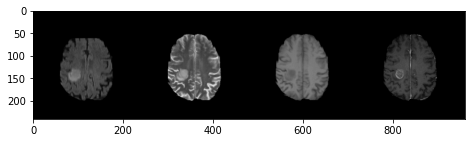

Label


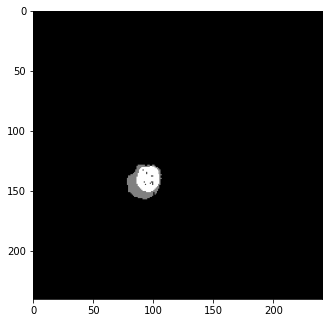

In [ ]:
print("HGG")
sitk_show(Tile(imgFOriginal[:, :, 105],
                         imgT2Original[:, :, 105],
                         imgT1Original[:, :, 105],
                         imgTCOriginal[:, :, 105],
                         (5, 1, 0)))

print("Label")
sitk_show(Tile(labelOrignal[:,:,105], (2,1,0)))

LGG


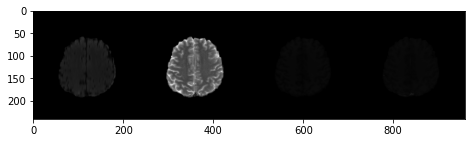

Label


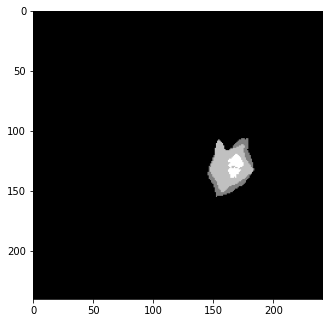

In [ ]:
print("LGG")
sitk_show(Tile(imgLFOriginal[:, :, idxSlice],
                         imgLT2Original[:, :, idxSlice],
                         imgLT1Original[:, :, idxSlice],
                         imgLTCOriginal[:, :, idxSlice],
                         (4, 1, 0)))

print("Label")
sitk_show(Tile(labelLOrignal[:,:,75],(2,1,0)))

In [6]:
idxSlice = 105
labelGrayMatter = 1

def get_output(path, lgg=False):
  for folder in tqdm(os.listdir(path)):
    folder_loc = join(path, folder)
    files = [join(folder_loc, x) for x in os.listdir(folder_loc)]
    files = sorted(files)
    imgF = files[0]; imgT1 = files[1]
    imgT2 = files[2]; imgTC = files[3]
    label = files[4]

    imgFOriginal = ReadImage(imgF)
    imgT1Original = ReadImage(imgT1)
    imgT2Original = ReadImage(imgT2)
    imgTCOriginal = ReadImage(imgTC)
    labelOrignal = ReadImage(label)

    samp = GetArrayFromImage(labelOrignal)

    for sliceidx in tqdm(range(0, samp.shape[0], 3)):
      if samp[sliceidx, :, :].sum() < 20:
        continue

      imgFSmooth = sitk.CurvatureFlow(image1=imgFOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
      imgT2Smooth = sitk.CurvatureFlow(image1=imgT2Original,
                                            timeStep=0.125,
                                            numberOfIterations=5)
      imgT1Smooth = sitk.CurvatureFlow(image1=imgT1Original,
                                            timeStep=0.125,
                                            numberOfIterations=5)

      imgTCSmooth = sitk.CurvatureFlow(image1=imgTCOriginal,
                                            timeStep=0.125,
                                            numberOfIterations=5)
      
      lstSeeds = [(145, 162, sliceidx),
              (98, 155, sliceidx),
              (175, 125, sliceidx),
              (155, 180, sliceidx)]
      
      imgGrayMatterF = sitk.ConfidenceConnected(image1=imgFSmooth, 
                                                  seedList=lstSeeds,
                                                  numberOfIterations=3,
                                                  multiplier=0.2,
                                                  replaceValue=labelGrayMatter)

      imgGrayMatterT2 = sitk.ConfidenceConnected(image1=imgT2Smooth, 
                                                      seedList=lstSeeds,
                                                      numberOfIterations=10,
                                                      multiplier=0.2,
                                                      replaceValue=labelGrayMatter)
      imgGrayMatterT1 = sitk.ConfidenceConnected(image1=imgT1Smooth, 
                                                      seedList=lstSeeds,
                                                      numberOfIterations=3,
                                                      multiplier=0.2,
                                                      replaceValue=labelGrayMatter)

      imgGrayMatterTC = sitk.ConfidenceConnected(image1=imgTCSmooth, 
                                                      seedList=lstSeeds,
                                                      numberOfIterations=3,
                                                      multiplier=0.2,
                                                      replaceValue=labelGrayMatter)

      imgGrayMatterLabel = sitk.ConfidenceConnected(image1=labelOrignal, 
                                                      seedList=lstSeeds,
                                                      numberOfIterations=3,
                                                      multiplier=0.2,
                                                      replaceValue=2)


      imgFSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgFSmooth), 
                                      imgGrayMatterF.GetPixelID())
      imgT2SmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT2Smooth), 
                                      imgGrayMatterT2.GetPixelID())
      imgT1SmoothInt = sitk.Cast(sitk.RescaleIntensity(imgT1Smooth), 
                                      imgGrayMatterT1.GetPixelID())
      imgTCSmoothInt = sitk.Cast(sitk.RescaleIntensity(imgTCSmooth), 
                                      imgGrayMatterTC.GetPixelID())
      imgLabelInt = sitk.Cast(sitk.RescaleIntensity(labelOrignal), 
                                      imgGrayMatterLabel.GetPixelID())
      
      img_op = "/content/data/brats13/images/"
      mask_op = "/content/data/brats13/masks/"
      base = imgF.split("/")[5] + "_" + str(sliceidx)
      if lgg:
        f_flair = join(img_op, base + "_flair_l.png")
        f_t1 = join(img_op, base + "_t1_l.png")
        f_t1c = join(img_op, base + "_t1c_l.png")
        f_t2 = join(img_op, base + "_t2_l.png")
        f_label = join(mask_op, base + "_l.png")
      else:
        f_flair = join(img_op, base + "_flair.png")
        f_t1 = join(img_op, base + "_t1.png")
        f_t1c = join(img_op, base + "_t1c.png")
        f_t2 = join(img_op, base + "_t2.png")
        f_label = join(mask_op, base + ".png")

      scan_f = GetArrayFromImage(imgFSmoothInt[:,:,sliceidx])/255
      scan_t1 = GetArrayFromImage(imgT1SmoothInt[:,:,sliceidx])/255
      scan_t1c = GetArrayFromImage(imgTCSmoothInt[:,:,sliceidx])/255
      scan_t2 = GetArrayFromImage(imgT2SmoothInt[:,:,sliceidx])/255
      scan_label = GetArrayFromImage(imgLabelInt[:,:,sliceidx])/255

      plt.imsave(f_flair, scan_f)
      plt.imsave(f_t1, scan_t1)
      plt.imsave(f_t1c, scan_t1c)
      plt.imsave(f_t2, scan_t2)
      plt.imsave(f_label, scan_label)

In [7]:
!rm -rf "/content/data/brats13/images/"
!rm -rf "/content/data/brats13/masks/"

In [8]:
!mkdir "/content/data/brats13/images/"
!mkdir "/content/data/brats13/masks/"

In [9]:
get_output("/content/data/brats13/HGG/")

100%|██████████| 20/20 [4:04:40<00:00, 734.03s/it]


In [ ]:
get_output("/content/data/brats13/LGG/", True)

 73%|███████▎  | 38/52 [02:35<07:15, 31.09s/it]

In [ ]:
!zip -q -r masks.zip "/content/data/brats13/masks/"
!zip -q -r images.zip "/content/data/brats13/images/"

!cp images.zip "/gdrive/MyDrive/Assignment 2/data/brats13/images2.zip"
!cp masks.zip "/gdrive/MyDrive/Assignment 2/data/brats13/masks2.zip"

In [3]:
BRATS_ = abs("../data/brats13")
imgs, masks = [], []

img_path = join(BRATS_, "images")
mask_path = join(BRATS_, "masks")

lgg_imgs = glob(abs(img_path) + "/*_l.png")
lgg_imgs = sorted(lgg_imgs)
lgg_masks = glob(abs(mask_path) + "/*_l.png")
lgg_masks = sorted(lgg_masks)

def open_file(path):
    filee = Image.open(path).convert("L")
    return np.array(filee)

for count, idx in enumerate(range(0, len(lgg_imgs), 4)):
    flair = open_file(lgg_imgs[idx])
    t1 = open_file(lgg_imgs[idx+1])
    t1c = open_file(lgg_imgs[idx+2])
    t2 = open_file(lgg_imgs[idx+3])
    mask = open_file(lgg_masks[count])
    imgs.append([flair, t1, t1c, t2])
    masks.append(mask)

In [5]:
hgg_imgs = [x for x in glob(abs(img_path) + "/*.png") if not x.endswith("_l.png")]
hgg_imgs = sorted(hgg_imgs)
hgg_masks = [x for x in glob(abs(mask_path) + "/*.png") if not x.endswith("_l.png")]
hgg_masks = sorted(hgg_masks)

for count, idx in enumerate(range(0, len(hgg_imgs), 4)):
    flair = open_file(hgg_imgs[idx])
    t1 = open_file(hgg_imgs[idx+1])
    t1c = open_file(hgg_imgs[idx+2])
    t2 = open_file(hgg_imgs[idx+3])
    mask = open_file(hgg_masks[count])
    imgs.append([flair, t1, t1c, t2])
    masks.append(mask)

imgs = np.array(imgs)
masks = np.array(masks)
masks = np.expand_dims(masks, 1)

In [6]:
imgs.shape, masks.shape

((610, 4, 240, 240), (610, 1, 240, 240))

In [7]:
np.save(join(BRATS_, "X.npy"), imgs)
np.save(join(BRATS_, "Y.npy"), masks)

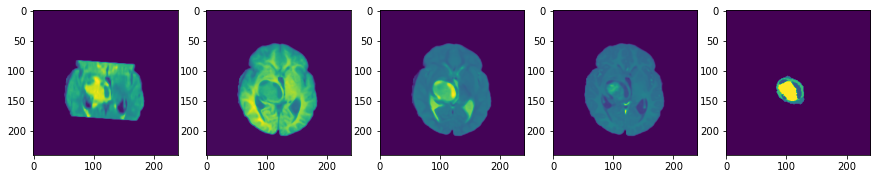

In [103]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

ax[0].imshow(imgs[10][0])
ax[1].imshow(imgs[10][1])
ax[2].imshow(imgs[10][2])
ax[3].imshow(imgs[10][3])
ax[4].imshow(masks[10][0])

In [17]:
class BRATS(Dataset):
	def __init__(self, pardir, transform=None):
		self.imgs = np.load(join(pardir,  "X.npy"))
		self.masks = np.load(join(pardir, "Y.npy"))

		self.data_len = len(self.imgs)
		self.transforms = transform

	def __len__(self):
		return self.data_len

	def __getitem__(self, index):
		img = self.imgs[index]/255
		mask = self.masks[index]/255

		if self.transforms:
			aug = self.transforms(image=img, mask=mask)
			aug_img = torch.Tensor(aug["image"])
			aug_mask = torch.Tensor(aug["mask"])
			return aug_img, aug_mask #torch.unsqueeze(aug_img, 0), torch.unsqueeze(aug_mask, 0)
		
		#int(img.shape, mask.shape)
		img = torch.Tensor(img)
		mask = torch.Tensor(mask)
		#print(img.shape, mask.shape)
		return img, mask

In [18]:
BRATS_ = abs("../data/brats13")

augs = A.Compose([
    A.RandomBrightnessContrast(brightness_by_max=False, p=0.5),
    A.Flip(p=0.5),
    A.Rotate(p=0.5),
], p=1)

brats_ds = BRATS(BRATS_, augs)
img, mask = brats_ds.__getitem__(20)

length = brats_ds.__len__()
splits = [int(np.ceil(length - 0.2*length)), int(0.2*length)] 
brats_train, brats_val = random_split(brats_ds, splits)

brats_tdl = DataLoader(brats_train, batch_size=64, shuffle=True)
brats_vdl = DataLoader(brats_val, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(brats_tdl))
val_features, val_labels = next(iter(brats_vdl))
print("Training batch shape:", train_features.size(), train_labels.size())
print("Validation batch shape:", val_features.size(), val_labels.size())

Training batch shape: torch.Size([64, 4, 240, 240]) torch.Size([64, 1, 240, 240])
Validation batch shape: torch.Size([64, 4, 240, 240]) torch.Size([64, 1, 240, 240])


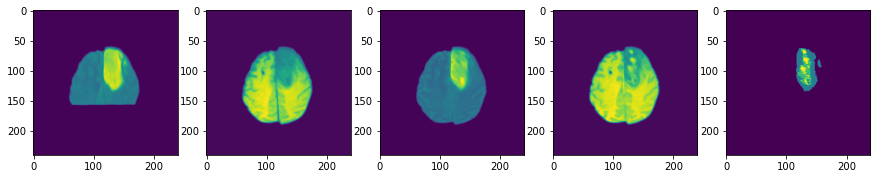

In [26]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
img, mask = ds.__getitem__(20)

ax[0].imshow(img[0][0])
ax[1].imshow(img[0][1])
ax[2].imshow(img[0][2])
ax[3].imshow(img[0][3])
ax[4].imshow(mask[0][0])